## HW 11 - Data fitting with various functions - Due Monday Nov 8, 2021


Dowload the data from the SDSS DR16:<br>
https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allStar-r12-l33.fits
NOTE: it is a large file and will take a while.


Using masking. Select the approprate fitting function and fit the following selections of the data:
1. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LogG (LOGG\_ERR)__<br>
<br>
2. Select stars only with with $GLAT < -10$ or $GLAT > 10$ <br>
   __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>
<br>
3. Select stars only with with $-2< GLAT < 2$ <br>
   __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>
<br>
4. Select stars only with with $GLAT < -10$ or $GLAT > 10$ <br>
   __Fit {\bf  TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit {\bf  GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>
6. __Fit {\bf NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>
7. __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For each of the above selections:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

ColDefs(
    name = 'APSTAR_ID'; format = '57A'
    name = 'TARGET_ID'; format = '47A'
    name = 'ASPCAP_ID'; format = '59A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    na

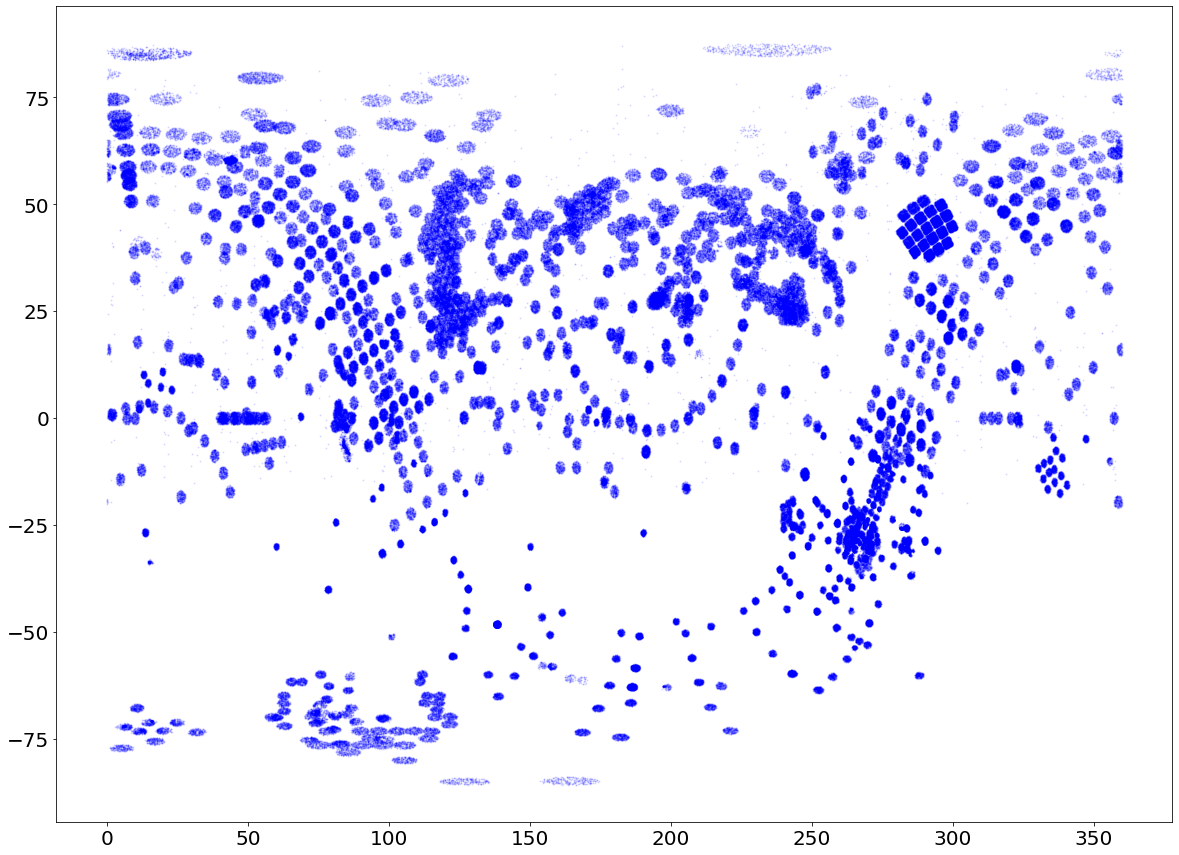

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d

def gausian(x,mu,sigma):
    part1 = (1.0/np.sqrt(2*np.pi*sigma**2))
    return (part1*(np.exp((-1*x - mu)**2/(2*sigma**2))))

def lorentzian_cauchy (x,a,b,c):
    return (c)*(b**2/((x-a)**2 + b**2))

def sigmoid(x,a,b,c,d):
    return (c/(1 + np.exp(-b*(x-a))) + d)

# READ IN FITS FILES
star_hdus = fits.open('allStar-r12-l33.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

In [2]:
def mcFit2(func, x, y, x_err, y_err, p0=[1,1]):
    slope = list()
    y_ints = list()
    iters = 100 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])

    return (np.median(slope),np.median(y_ints))


def mcFit3(func, x, y, x_err, y_err,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 100 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

def mcFit4(func, x, y, x_err, y_err, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 100 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])

    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


# READ IN FITS FILES
star_hdus = fits.open('allStar-r12-l33.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APSTAR_ID'; format = '57A'
    name = 'TARGET_ID'; format = '47A'
    name = 'ASPCAP_ID'; format = '59A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    na

In [ ]:
# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR:  0.0011991871856501296 -3.3380668938557148
COSFIT:  0.00871789206376521 0.019939184037695894 0.05184183810372808 2.005121297438194
poly2:  -2.0676397711690943e-07 0.0032844823667633185 -8.428534019560832
Poly3:  2.2449209499503593e-12 -2.4428195576946073e-07 0.0034819532213921514 -8.76121487740306


<ipython-input-1-7145d2d7e1e6>:23: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x + c) + d


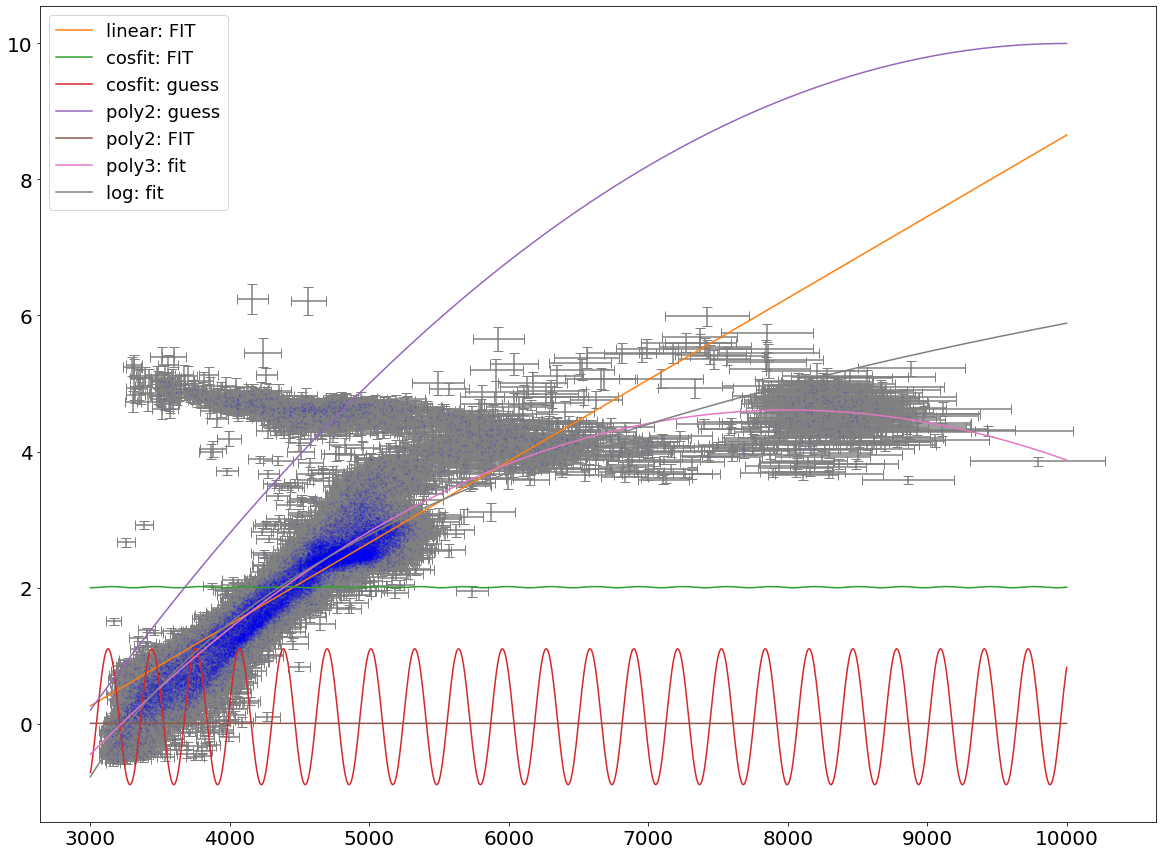

In [3]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < 1) & (star['GLAT'] > -1) & (star['TEFF']>0) & (star['LOGG']> -9000)
cut1 = np.where(ct1)[0]


## LINEAR FIT
slope, intercept = mcFit2(linear, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], star['LOGG_ERR'][cut1])
print("LINEAR: ",slope, intercept)

## COSFITS
prAcos, prBcos, prCcos, prDcos = mcFit4(cosfit, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], star['LOGG_ERR'][cut1],p0=[1, 0.02, 0.3, 0.1])
print("COSFIT: ",prAcos, prBcos, prCcos, prDcos)

## poly2
prA, prB, prC = mcFit3(poly2, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], star['LOGG_ERR'][cut1])##p0=[-2e-7,0.004,-10])
print("poly2: ",prA, prB, prC)

##exponential
#prA, prB, prC, prD = mcFit4(exponential, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], star['LOGG_ERR'][cut1])
#print("EXPONENTIAL: ",prA, prB, prC, prD)

##poly3
prA, prB, prC, prD = mcFit4(poly3, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], star['LOGG_ERR'][cut1])
print("Poly3: ",prA, prB, prC, prD)

##logfit
prlogA, prlogB, prlogC, prlogD = mcFit4(logfit, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], star['LOGG_ERR'][cut1])#,p0=[60,0.02,0,0])
#print("logfit: ",prA, prB, prC, prD)

## lorentzian_cauchy
#prA, prB, prC = mcFit3(lorentzian_cauchy, star['TEFF'][cut1], star['LOGG'][cut1], star['LOGG_ERR'][cut1]/1000, star['TEFF_ERR'][cut1]/1000,p0=[60,0.02,0.0])
#print("lorentzian_cauchy: ",prA, prB, prC)

##sigmoid
#prA, prB, prC, prD = mcFit4(sigmoid, star['TEFF'][cut1], star['LOGG'][cut1], star['LOGG_ERR'][cut1]/1000, star['TEFF_ERR'][cut1]/1000,p0=[60,0.02,0,0])
#print("sigmoid: ",prA, prB, prC, prD)

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(20,15))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1],star['LOGG'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1]),star['LOGG'][cut1], xerr=(star['TEFF_ERR'][cut1]), yerr=(star['LOGG_ERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)

# PLOT FITS
x_plot = np.linspace(3000,10000,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, prAcos, prBcos, prCcos, prDcos), label='cosfit: FIT')
ax1.plot(x_plot,cosfit(x_plot, 1, 0.02, 0.3, 0.1), label='cosfit: guess')
#poly2
ax1.plot(x_plot,poly2(x_plot,-2e-7,0.004,-10), label='poly2: guess')
ax1.plot(x_plot,poly2(x_plot,prA, prB, prC), label='poly2: FIT')
#poly3
ax1.plot(x_plot,poly3(x_plot,prA, prB, prC, prD), label='poly3: fit')
#logfit
ax1.plot(x_plot,logfit(x_plot,prlogA, prlogB, prlogC, prlogD), label='log: fit')
                                       
plt.legend(loc='best', fontsize=18)
plt.show()



LINEAR:  -0.1976366523514237 0.047748631759196386
COSFIT:  -0.15236157038858653 1.8091645707806059 -0.6815759159617439 0.15504884015847403
POLY2:  0.015329923456212383 -0.18918570412842362 0.047147905406481214
Poly3:  0.10386203821385348 0.16685259826117171 -0.17630001870408707 0.03797928529906999


<ipython-input-1-7145d2d7e1e6>:23: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x + c) + d
/Users/hopesage/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


logfit:  0.5 0.5 0.5 0.5
lorentzian:  -0.9841684623630123 0.4490753380032233 0.307891627254962
sigmoid:  -0.42768617741547144 3.872854450674146 -0.3053566723424396 0.29210209707322965


<ipython-input-1-7145d2d7e1e6>:23: RuntimeWarning: divide by zero encountered in log
  return a*np.log(b*x + c) + d
<ipython-input-1-7145d2d7e1e6>:23: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x + c) + d
<ipython-input-1-7145d2d7e1e6>:23: RuntimeWarning: divide by zero encountered in log
  return a*np.log(b*x + c) + d
<ipython-input-1-7145d2d7e1e6>:23: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x + c) + d


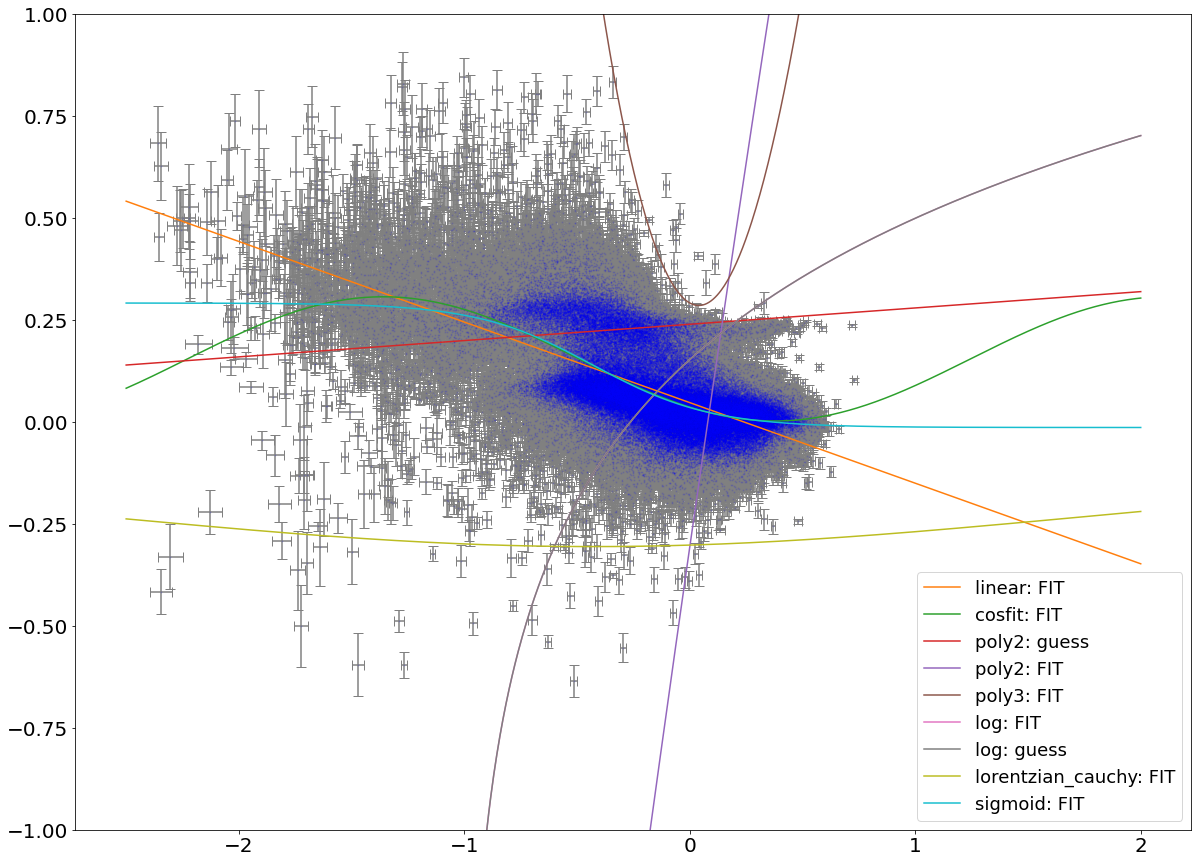

In [4]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < 10) & (star['GLAT'] > -10) & (star['Fe_H']>-9000) & (star['O_FE']> -9000)
cut1 = np.where(ct1)[0]


## LINEAR FIT
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1])
print("LINEAR: ",slope, intercept)

## COSFITS
prcosA, prcosB, prcosC, prcosD = mcFit4(cosfit, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1], p0=[1, 2, 0, 0])
print("COSFIT: ",prcosA, prcosB, prcosC, prcosD)

## poly2
prA, prB, prC = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1],p0= [0,0.04,0.24])
print("POLY2: ",prA, prB, prC)

##poly3
prA, prB, prC, prD = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1])
print("Poly3: ",prA, prB, prC, prD)

## logfit
prlogA, prlogB, prlogC, prlogD = mcFit4(logfit, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1], p0= [0.5, 0.5, 0.5, 0.5])
print("logfit: ",prlogA, prlogB, prlogC, prlogD)

#lorentzian= 
prA, prB, prC = mcFit3(lorentzian_cauchy, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1])
print("lorentzian: ",prA, prB, prC)

#sigmoid
prA, prB, prC, prD = mcFit4(sigmoid, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1],p0=[1,1,1,1])
print("sigmoid: ",prA, prB, prC, prD)

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(20,15))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['Fe_H'][cut1]),star['O_FE'][cut1], xerr=(star['Fe_H_ERR'][cut1]), yerr=(star['O_FE_ERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)

# PLOT FITS
x_plot = np.linspace(-2.5,2,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, prcosA, prcosB, prcosC, prcosD), label='cosfit: FIT')
#poly2
ax1.plot(x_plot,poly2(x_plot,0,0.04,0.24), label='poly2: guess')
ax1.plot(x_plot,poly2(x_plot, prA, prB, prC), label='poly2: FIT')
#poly3
ax1.plot(x_plot,poly3(x_plot, prA, prB, prC, prD), label='poly3: FIT')
#logfit
ax1.plot(x_plot,logfit(x_plot, prlogA, prlogB, prlogC, prlogD), label='log: FIT')
ax1.plot(x_plot,logfit(x_plot, 0.5, 0.5, 0.5, 0.5), label='log: guess')
#lorenztian
ax1.plot(x_plot,lorentzian_cauchy(x_plot, prA, prB, prC), label='lorentzian_cauchy: FIT')
#sigmoid
ax1.plot(x_plot,sigmoid(x_plot, prA, prB, prC, prD), label='sigmoid: FIT')
ax1.set_ylim(-1,1)

plt.legend(loc='best', fontsize=18)
plt.show()



In [8]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < 2) & (star['GLAT'] > -2) & (star['Fe_H']>-9000) & (star['O_FE']> -9000)
cut1 = np.where(ct1)[0]


## LINEAR FIT
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1])
print("LINEAR: ",slope, intercept)

## COSFITS
prcosA, prcosB, prcosC, prcosD = mcFit4(cosfit, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1],p0=[0,0,0,0])
print("COSFIT: ",prcosA, prcosB, prcosC, prcosD)

## poly2
prA, prB, prC = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1], p0= [0,0.04,0.24])
print("POLY2: ",prA, prB, prC)

##exponential
#prA, prB, prC, prD = mcFit4(exponential, star['Fe_H'][cut1], star['O_FE'][cut1], star['O_FE_ERR'][cut1], star['Fe_H_ERR'][cut1])
#print("EXPONENTIAL: ",prA, prB, prC, prD)

##poly3
prA, prB, prC, prD = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1], star['O_FE_ERR'][cut1], star['Fe_H_ERR'][cut1])
print("Poly3: ",prA, prB, prC, prD)

## logfit
prlogA, prlogB, prlogC, prlogD = mcFit4(logfit, star['Fe_H'][cut1], star['O_FE'][cut1], star['O_FE_ERR'][cut1], star['Fe_H_ERR'][cut1], p0=[0.5, 0.5, 0.5, 0.5])
print("logfit: ",prlogA, prlogB, prlogC, prlogD)

#lorentzian= 
prA, prB, prC = mcFit3(lorentzian_cauchy, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1])
print("lorentzian: ",prA, prB, prC)

#sigmoid
#prA, prB, prC, prD = mcFit4(sigmoid, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1])
#print("sigmoid: ",prA, prB, prC, prD)

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(20,15))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(star['FE_H_ERR'][cut1]), yerr=(star['O_FE_ERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)

# PLOT FITS
x_plot = np.linspace(-3,2,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, prcosA, prcosB, prcosC, prcosD), label='cosfit: FIT')
ax1.plot(x_plot,cosfit(x_plot, 0, 0, 0, 0), label='cosfit: guess')
#poly2
ax1.plot(x_plot,poly2(x_plot,0,0.04,0.24), label='poly2: guess')
ax1.plot(x_plot,poly2(x_plot, prA, prB, prC), label='poly2: FIT')
#poly3
ax1.plot(x_plot,poly3(x_plot, prA, prB, prC, prD), label='poly3: FIT')
#logfit
ax1.plot(x_plot,logfit(x_plot, prlogA, prlogB, prlogC, prlogD), label='log: FIT')
ax1.plot(x_plot,logfit(x_plot, 0.5, 0.5, 0.5, 0.5), label='log: guess')
#lorenztian
ax1.plot(x_plot,lorentzian_cauchy(x_plot, prA, prB, prC), label='lorentzian_cauchy: FIT')
#sigmoid
#ax1.plot(x_plot,sigmoid(x_plot, prA, prB, prC, prD), label='sigmoid: FIT')
ax1.set_ylim(-1,1)


plt.legend(loc='best', fontsize=18)
plt.show()

TypeError: linear() takes 3 positional arguments but 37893 were given

In [ ]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < 10) & (star['GLAT'] > -10) & (star['TEFF']>-9000) & (star['O_FE']> -9000)
cut1 = np.where(ct1)[0]


## LINEAR FIT
slope, intercept = mcFit2(linear, star['TEFF'][cut1], star[('J-K')][cut1], star['TEFF_ERR'][cut1], star['J_ERR, K_ERR'][cut1])
print("LINEAR: ",slope, intercept)

## COSFITS
prcosA, prcosB, prcosC, prcosD = mcFit4(cosfit, star['TEFF'][cut1], star['J'-'K'][cut1], star['TEFF_ERR'][cut1], star['J_ERR, K_ERR'][cut1], p0=[1, 2, 0, 0])
print("COSFIT: ",prcosA, prcosB, prcosC, prcosD)

## poly2
prA, prB, prC = mcFit3(poly2, star['TEFF'][cut1], star['J'-'K'][cut1], star['TEFF_ERR'][cut1], star['J_ERR, K_ERR'][cut1],p0= [0,0.04,0.24])
print("POLY2: ",prA, prB, prC)

##poly3
prA, prB, prC, prD = mcFit4(poly3, star['TEFF'][cut1], star['J'-'K'][cut1], star['TEFF_ERR'][cut1], star['O_FE_ERR'][cut1])
print("Poly3: ",prA, prB, prC, prD)

## logfit
prlogA, prlogB, prlogC, prlogD = mcFit4(logfit, star['TEFF'][cut1], star['J'-'K'][cut1], star['TEFF_ERR'][cut1], star['O_FE_ERR'][cut1], p0= [0.5, 0.5, 0.5, 0.5])
print("logfit: ",prlogA, prlogB, prlogC, prlogD)

#lorentzian= 
prA, prB, prC = mcFit3(lorentzian_cauchy, star['TEFF'][cut1], star['J'-'K'][cut1], star['TEFF_ERR'][cut1], star['O_FE_ERR'][cut1])
print("lorentzian: ",prA, prB, prC)

#sigmoid
prA, prB, prC, prD = mcFit4(sigmoid, star['TEFF'][cut1], star['J'-'K'][cut1], star['TEFF_ERR'][cut1], star['O_FE_ERR'][cut1],p0=[1,1,1,1])
print("sigmoid: ",prA, prB, prC, prD)

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(20,15))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1],star['J'-'K'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1]),star['J'-'K'][cut1], xerr=(star['TEFF_ERR'][cut1]), yerr=(star['O_FE_ERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)

# PLOT FITS
x_plot = np.linspace(-2.5,2,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, prcosA, prcosB, prcosC, prcosD), label='cosfit: FIT')
#poly2
ax1.plot(x_plot,poly2(x_plot,0,0.04,0.24), label='poly2: guess')
ax1.plot(x_plot,poly2(x_plot, prA, prB, prC), label='poly2: FIT')
#poly3
ax1.plot(x_plot,poly3(x_plot, prA, prB, prC, prD), label='poly3: FIT')
#logfit
ax1.plot(x_plot,logfit(x_plot, prlogA, prlogB, prlogC, prlogD), label='log: FIT')
ax1.plot(x_plot,logfit(x_plot, 0.5, 0.5, 0.5, 0.5), label='log: guess')
#lorenztian
ax1.plot(x_plot,lorentzian_cauchy(x_plot, prA, prB, prC), label='lorentzian_cauchy: FIT')
#sigmoid
ax1.plot(x_plot,sigmoid(x_plot, prA, prB, prC, prD), label='sigmoid: FIT')
ax1.set_ylim(-1,1)

plt.legend(loc='best', fontsize=18)
plt.show()



In [6]:
def mcFit2(func, x, y, y_err, p0=[1,1]):
    slope = list()
    y_ints = list()
    iters = 100 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])

    return (np.median(slope),np.median(y_ints))


def mcFit3(func, x, y, y_err,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 100 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

def mcFit4(func, x, y, y_err, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 100 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])

    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


# READ IN FITS FILES
star_hdus = fits.open('allStar-r12-l33.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APSTAR_ID'; format = '57A'
    name = 'TARGET_ID'; format = '47A'
    name = 'ASPCAP_ID'; format = '59A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    na

In [10]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < 10) & (star['GLAT'] > -10) & (star['GLON']>-9000) & (star['VHEILO_AVG']> -9000)
cut1 = np.where(ct1)[0]


## LINEAR FIT
slope, intercept = mcFit2(linear, star['GLON'][cut1], star['VHEILO_AVG'][cut1], star['VERR'][cut1])
print("LINEAR: ",slope, intercept)

## COSFITS
prcosA, prcosB, prcosC, prcosD = mcFit4(cosfit, star['GLON'][cut1], star['VHEILO_AVG'][cut1], star['VERR'][cut1], p0=[1, 2, 0, 0])
print("COSFIT: ",prcosA, prcosB, prcosC, prcosD)

## poly2
prA, prB, prC = mcFit3(poly2, star['GLON'][cut1], star['VHEILO_AVG'][cut1], star['VERR'][cut1],p0= [0,0.04,0.24])
print("POLY2: ",prA, prB, prC)

##poly3
prA, prB, prC, prD = mcFit4(poly3, star['GLON'][cut1], star['VHEILO_AVG'][cut1], star['VERR'][cut1])
print("Poly3: ",prA, prB, prC, prD)

## logfit
prlogA, prlogB, prlogC, prlogD = mcFit4(logfit, star['GLON'][cut1], star['VHEILO_AVG'][cut1], star['VERR'][cut1], p0= [0.5, 0.5, 0.5, 0.5])
print("logfit: ",prlogA, prlogB, prlogC, prlogD)

#lorentzian= 
prA, prB, prC = mcFit3(lorentzian_cauchy, star['GLON'][cut1], star['VHEILO_AVG'][cut1], star['VERR'][cut1])
print("lorentzian: ",prA, prB, prC)

#sigmoid
prA, prB, prC, prD = mcFit4(sigmoid, star['GLON'][cut1], star['VHEILO_AVG'][cut1], star['VERR'][cut1],p0=[1,1,1,1])
print("sigmoid: ",prA, prB, prC, prD)

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(20,15))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['GLON'][cut1],star['VHEILO_AVG'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['GLON'][cut1]),star['VHEILO_AVG'][cut1], yerr=(star['VERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)

# PLOT FITS
x_plot = np.linspace(-2.5,2,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, prcosA, prcosB, prcosC, prcosD), label='cosfit: FIT')
#poly2
ax1.plot(x_plot,poly2(x_plot,0,0.04,0.24), label='poly2: guess')
ax1.plot(x_plot,poly2(x_plot, prA, prB, prC), label='poly2: FIT')
#poly3
ax1.plot(x_plot,poly3(x_plot, prA, prB, prC, prD), label='poly3: FIT')
#logfit
ax1.plot(x_plot,logfit(x_plot, prlogA, prlogB, prlogC, prlogD), label='log: FIT')
ax1.plot(x_plot,logfit(x_plot, 0.5, 0.5, 0.5, 0.5), label='log: guess')
#lorenztian
ax1.plot(x_plot,lorentzian_cauchy(x_plot, prA, prB, prC), label='lorentzian_cauchy: FIT')
#sigmoid
ax1.plot(x_plot,sigmoid(x_plot, prA, prB, prC, prD), label='sigmoid: FIT')
ax1.set_ylim(-1,1)

plt.legend(loc='best', fontsize=18)
plt.show()



KeyError: "Key 'VHEILO_AVG' does not exist."

In [ ]:


badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['NVISITS'] >=1) 
cut1 = np.where(ct1)[0]


## LINEAR FIT
slope, intercept = mcFit2(linear, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1])
print("LINEAR: ",slope, intercept)

## COSFITS
prcosA, prcosB, prcosC, prcosD = mcFit4(cosfit, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1], p0=[1, 2, 0, 0])
print("COSFIT: ",prcosA, prcosB, prcosC, prcosD)

## poly2
prA, prB, prC = mcFit3(poly2, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1],p0= [0,0.04,0.24])
print("POLY2: ",prA, prB, prC)

##poly3
prA, prB, prC, prD = mcFit4(poly3, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1])
print("Poly3: ",prA, prB, prC, prD)

## logfit
prlogA, prlogB, prlogC, prlogD = mcFit4(logfit, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1], p0= [0.5, 0.5, 0.5, 0.5])
print("logfit: ",prlogA, prlogB, prlogC, prlogD)

#lorentzian= 
prA, prB, prC = mcFit3(lorentzian_cauchy, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1])
print("lorentzian: ",prA, prB, prC)

#sigmoid
#prA, prB, prC, prD = mcFit4(sigmoid, star['NVISITS'][cut1], star['VSCATTER'][cut1], star['VERR'][cut1],p0=[1,1,1,1])
#print("sigmoid: ",prA, prB, prC, prD)

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(20,15))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['NVISITS'][cut1],star['VSCATTER'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['NVISITS'][cut1]),star['VSCATTER'][cut1], yerr=(star['VERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)

# PLOT FITS
x_plot = np.linspace(-2.5,2,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, prcosA, prcosB, prcosC, prcosD), label='cosfit: FIT')
#poly2
ax1.plot(x_plot,poly2(x_plot,0,0.04,0.24), label='poly2: guess')
ax1.plot(x_plot,poly2(x_plot, prA, prB, prC), label='poly2: FIT')
#poly3
ax1.plot(x_plot,poly3(x_plot, prA, prB, prC, prD), label='poly3: FIT')
#logfit
ax1.plot(x_plot,logfit(x_plot, prlogA, prlogB, prlogC, prlogD), label='log: FIT')
ax1.plot(x_plot,logfit(x_plot, 0.5, 0.5, 0.5, 0.5), label='log: guess')
#lorenztian
ax1.plot(x_plot,lorentzian_cauchy(x_plot, prA, prB, prC), label='lorentzian_cauchy: FIT')
#sigmoid
#ax1.plot(x_plot,sigmoid(x_plot, prA, prB, prC, prD), label='sigmoid: FIT')
#ax1.set_ylim(-1,1)

plt.legend(loc='best', fontsize=18)
plt.show()

